### Import data

In [ ]:
import CSV
using LeastSquaresOptim, DifferentialEquations, DelayDiffEq, DiffEqBase, Optim, Plots, Statistics, DataFrames

function get_data(path_g2, path_total)
    # Import data
    data = CSV.read(path_g2)
    total = CSV.read(path_total)

    # delete the extra index column
    deletecols!(data, 1:2)
    deletecols!(total, 1:2)

    # getting all the 8 trials
    drug = data[:, 1:8]
    pop = total[:, 1:8]

    # rescaling the experimental data assuming we have 20 initial cells for each trial
    g1 = zeros(size(drug, 1), 8)
    g2 = zeros(size(drug, 1), 8)
    g1_0 = zeros(8)
    g2_0 = zeros(8)

    init_cells = 20.0

    # Unifying the dataset to be all in the unit of [# of cells] at each time point forall the trials for a drug
    for i in 1:8
        pop[:, i] = init_cells*pop[:, i]
        g2[:, i] = 0.01*pop[:, i] .* drug[:, i]
        g1[:, i] = pop[:, i] .- g2[:, i]
        g2_0[i] = init_cells*(drug[1, i]/100.0)
        g1_0[i] = init_cells*(1 - drug[1, i]/100.0)
    end
    return pop, g2, g1, g2_0, g1_0
end

pop, g2, g1, g2_0, g1_0 = get_data("..//data//gem.csv", "..//data//gem_pop.csv");
# i is the number of the column we are using from the data

In [ ]:
i = 8
function DDEmodel(du, u, h, p, t)
    du[1] = -p[1]*(h(p, t-p[3])[1]) + 2*p[2]*(h(p, t-p[4])[2]) - p[6]*u[1]
    du[2] = p[1]*(h(p, t-p[3])[1]) - p[2]*(h(p, t-p[4])[2]) - p[7]*u[2]
end

function DDEsolve(pp)
    lags = [pp[3], pp[4]]
    h(p, t) = pp[5]*ones(2)
    t = LinRange(0.0, 95.5, 192)
    tspan = (0.0, 95.5)
    u0 = [g1_0[i], g2_0[i]]
    prob = DDEProblem(DDEmodel, u0, h, tspan, pp; constant_lags = lags)
    solve(prob)
end

function resid(pp)
    t = LinRange(0.0, 95.5, 192)
    res = zeros(2, 192)
    sol = DDEsolve(pp)
    res[1, :] = sol(t, idxs=1).u - g1[:, i]
    res[2, :] = sol(t, idxs=2).u - g2[:, i]
    return res
end

p  = [0.0571958, 0.0326492, 0.7504399, 4.501804, 19.3794, 0.00560244, 0.00236748]
# setting lowest delay for tau1 to be half an hour and for tau2 to be 3 hours.
low = [0.0001, 0.0001, 0.5, 3.0, 1.0, 0.0001, 0.0001]
upp = [0.5, 0.5, 30.0, 30.0, 200.0, 0.5, 0.5]

function optimIt(p, low, upp)
    results_dde = optimize(resid, p, LevenbergMarquardt(), lower = low, upper = upp)
    return results_dde.minimizer
end

params = optimIt(p, low, upp)

# param_gem_dde = zeros(8, 9)
# param_gem_dde[:, 2] = params
# CSV.write("param_gem_dde.csv", DataFrame(param_gem_dde))
# param_gem_dde = CSV.read("param_gem_dde.csv")
# param_gem_dde[:, 1] = ["alpha", "beta", "tau1", "tau2", "history", "gamma1", "gamma2", "drug concentration"]
# CSV.write("param_gem_dde.csv", DataFrame(param_gem_dde))

function plotIt(params, drug_name)
    lags = [params[3], params[4]]
    t = LinRange(0.0, 95.5, 192)
    t_new = LinRange(0.0, 195.5, 292)
    h(p, t_new) = params[5]*ones(2)
    tspan_new = (0.0, 195.5)
    u0_new = [g1_0[i], g2_0[i]]
    prob_new = DDEProblem(DDEmodel, u0_new, h, tspan_new, params; constant_lags = lags)
    solution = solve(prob_new, MethodOfSteps(Tsit5()))

    plot(t_new, solution(t_new, idxs=1).u, label = "G1 est", dpi = 150, xlabel = "time [hours]", ylabel = "# of cells")
    plot!(t, g1[:, i], label = "G1", dpi = 150)
    plot!(t_new, solution(t_new, idxs=2).u, label = "G2 est", title = drug_name, legend=:topright, dpi = 150)
    plot!(t, g2[:, i], label = "G2", dpi = 150)
    plot!(t_new, (solution(t_new, idxs=2).u + solution(t_new, idxs=1).u), label = "total est", dpi = 150)
    plot!(t, pop[:, i], label = "total", dpi = 150)
    # savefig("gem_3_dde_long.png")
end
plotIt(params, "Gemcitabine Trial 8")

### To plot parameters against drug concentrations

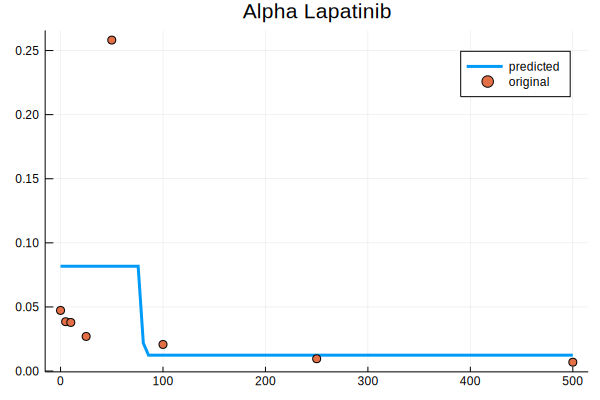

In [9]:
using Plots, CSV, Optim, LsqFit;

# Reading the file containing params
param_lap_dde = CSV.read(".//figures//Lapatinib//dde//params_lap_DDE.csv")
param_gem_dde = CSV.read(".//figures//Gem//dde//params_gem_DDE.csv")
param_dox_dde = CSV.read(".//figures//Dox//dde//params_dox_DDE.csv")
param_taxol1_dde = CSV.read(".//figures//taxol//dde//params_taxol1_DDE.csv")
param_tax2_dde = CSV.read(".//figures//taxol2//dde//params_tax2_DDE.csv")

# Convert the DataFrame to Matrix for plotting
lap = convert(Matrix, param_lap_dde[:,2:end])
gem = convert(Matrix, param_gem_dde[:,2:end])
dox = convert(Matrix, param_dox_dde[:,2:end])
tax = convert(Matrix, param_taxol1_dde[:,2:end])
tax2 = convert(Matrix, param_tax2_dde[:, 2:end])

@. dose_response(x, p) =  p[1] + ((p[2] - p[1]) / (1 + 10^((x - p[3]))))
""" The original formula:
y = bottom + [(top - bottom) / ( 1 + 10^(x - log EC50) )]
note that bottom is up, top is down! Notice how to choose EC50 based on drug concentrations
"""
function HillFit(drug, param_Dname, initial_guess)
    xdata = drug[8, :]
    ydata = drug[1, :]
    initial_p = initial_guess

    # fit data
    fit = curve_fit(dose_response, xdata, ydata, initial_p)
    par = fit.param
    # par = [1.01, 1.21, -0.03, -100.0]

    new_xdata = LinRange(minimum(xdata), maximum(xdata), 100)
    new_ydata = dose_response(new_xdata, par)

    plot(new_xdata, new_ydata, title = param_Dname, label = "predicted", linewidth=3)
    scatter!(xdata, ydata, label = "original ")
end

initial_guess = [1.35, 0.01, 80.0]
p_d = "Alpha Lapatinib"
HillFit(gem, p_d, initial_guess)
HillFit(lap, p_d, initial_guess)

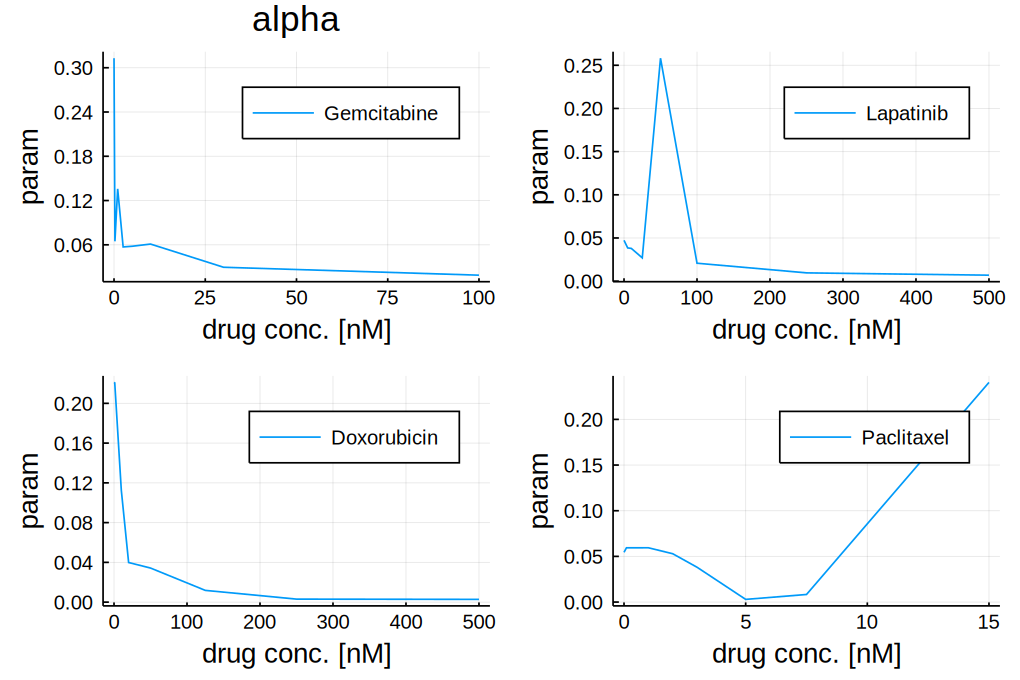

In [10]:
function plot_param_conc(lap, gem, dox, tax, i, param)
    """ This function to plot parameter vs. concentraition.
    Arguments:
    ----------
    lap, gem, dox, tax: DataFrame containing parameters of treating AU565 human breast cancer cells with Lapatinib, Gemcitabine, Doxorubicin, and   Paclitaxel1, respectively.
    i {int.}: If it is for DDE: A number between 1 and 7, which points to the parameters: [alpha, beta, tau1, tau2, history, gamma1, gamma2]
              If it is for ODE: A number between 1 and 4, which points to the parameters: [alpha, beta, gamma1, gamma2]
    param {str.}: a string used for the title of plots, to show which parameter we are plotting.
    Returns:
    --------
    Returns a 2x2 plot for four drugs. 
    
    """
    p1 = plot(gem[8, :], gem[i, :], label = "Gemcitabine", title = param, xlabel = "drug conc. [nM]", ylabel = "param", yticks = 0.0:round(maximum(gem[i, :])/5, digits = 2):maximum(gem[i, :]))
    p2 = plot(lap[8, :], lap[i, :], label = "Lapatinib", xlabel = "drug conc. [nM]", ylabel = "param", yticks = 0.0:round(maximum(lap[i, :])/5, digits = 2):maximum(lap[i, :]))
    p3 = plot(dox[8, :], dox[i, :], label = "Doxorubicin", xlabel = "drug conc. [nM]", ylabel = "param", yticks = 0.0:round(maximum(dox[i, :])/5, digits =2):maximum(dox[i, :]))
    p4 = plot(tax[8, :], tax[i, :], label = "Paclitaxel", xlabel = "drug conc. [nM]", ylabel = "param", yticks = 0.0:round(maximum(tax[i, :])/5, digits=2):maximum(tax[i, :]))
    plot(p1, p2, p3, p4, figsize = (18, 8), dpi = 170)
end

plot_param_conc(lap, gem, dox, tax2, 1 , "alpha")
# savefig()